In this article, we present a revolutionary and innovative solution to address food waste and optimize processes in the gastronomic industry. By utilizing transfer learning techniques and the pre-trained ResNet-18 model, we propose a fruit classification system that will enable restaurants and food companies to efficiently manage fresh produce and minimize waste.

Food waste is a critical problem in the gastronomic industry. Restaurants and food companies often face challenges when trying to properly handle the large amount of fruit they receive daily. The lack of accurate and efficient fruit classification can result in significant losses due to spoiled products, incorrect selection, or lack of inventory tracking.

Our proposal is based on the use of transfer learning and the pre-trained ResNet-18 model to accurately and automatically classify fruits. By leveraging the knowledge acquired by the neural network in previous image classification tasks, we can quickly train a model that is capable of distinguishing between different types of fruits.

## Import necessary libraries and modules
To begin, we import the necessary libraries and modules for our fruit classification project. These include essential components of the PyTorch framework, such as modules for neural network architectures (nn), optimization algorithms (optim), data transformation utilities (transforms), and data loading utilities (DataLoader). We also import other necessary libraries such as PIL for image processing, tqdm for progress tracking, and numpy for numerical operations.

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split

## Custom dataset
Class Next, we define a custom dataset class called FruitDataset. This class allows us to load and preprocess fruit images for training and validation. The dataset is initialized with a list of file paths and their corresponding labels. The class provides methods to get the length of the dataset, get an item (image and label) at a specific index, and perform necessary transformations on the images.

In [2]:
class FruitDataset(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        self.classes = sorted(list(set([label for _, label in files])))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path, label = self.files[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.classes.index(label)
        return img, label

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

##  Data Preprocessing and Splitting
We define data transformation pipelines for the training and validation sets. These transformations include random resizing and cropping, horizontal flipping, random rotation, color adjustment, conversion to tensors, and normalization. These transformations help improve the model’s ability to generalize to different variations of fruit images.

We collect all file paths and labels from the dataset and split them into training and validation sets using the train_test_split function from scikit-learn. The split is performed with a training fraction of 0.8, ensuring that both sets have representative samples from each fruit class.

In [4]:
root_dir = '/kaggle/input/60-fruit-types-curated-dataset'
subfolders = ['/kaggle/input/60-fruit-types-curated-dataset/A - E', '/kaggle/input/60-fruit-types-curated-dataset/F-M', '/kaggle/input/60-fruit-types-curated-dataset/M-R', '/kaggle/input/60-fruit-types-curated-dataset/S-Y']

all_files = []
for subfolder in subfolders:
    for fruit in os.listdir(os.path.join(root_dir, subfolder)):
        fruit_files = os.listdir(os.path.join(root_dir, subfolder, fruit))
        all_files.extend([(os.path.join(root_dir, subfolder, fruit, f), fruit) for f in fruit_files])

train_frac = 0.8
train_files, val_files = train_test_split(all_files, train_size=train_frac, random_state=42, stratify=[label for _, label in all_files])

train_dataset = FruitDataset(train_files, transform=data_transforms['train'])
val_dataset = FruitDataset(val_files, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

dataloaders = {'train': train_loader, 'val': val_loader}


# Model Training
The next step involves training the fruit classifier using transfer learning with a pre-trained ResNet-18 model. We load the pre-trained ResNet-18 model on ImageNet and replace the last fully connected layer with a new linear layer that matches the number of fruit classes in our dataset.

We move the model to the available GPU device, if available, to leverage its computational power. The loss function used is the cross-entropy loss, and the optimizer used is stochastic gradient descent (SGD) with a learning rate of 0.001 and momentum of 0.9. Additionally, a step scheduler with a step size of 7 and a gamma value of 0.1 is employed to adjust the learning rate during training. The number of training epochs is set to 100.

The training loop iterates over each epoch and, for each epoch, goes through both the training and validation sets. During each iteration, the loss and accuracy are calculated, and the results are printed. The model’s state is saved every 5 epochs.

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Get the number of features in the last layer
num_features = model.fc.in_features

# Replace the last layer with a new linear layer to match the number of fruit classes
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(num_features, num_classes)

# Move the model to GPU if available
model = model.to(device)

# Define the criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 100

train_losses = []
val_losses = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Wrap the dataloader with tqdm to display a progress bar
        pbar = tqdm(dataloaders[phase], desc=f"{phase.capitalize()} phase", unit="batch")
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Update the progress bar description
            pbar.set_postfix(loss=(running_loss / ((pbar.n + 1) * 32)),
                 acc=((running_corrects.double() / ((pbar.n + 1) * 32)).item()))

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


        if phase == 'train':
            train_losses.append(epoch_loss)
        else:
            val_losses.append(epoch_loss)
        
    if epoch % 5 == 0:
        torch.save(model.state_dict(), f'fruit_classifier_{epoch}.pth')

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 1/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  10%|█         | 24/229 [00:42<05:02,  1.48s/batch, acc=0.0234, loss=4.08]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [06:10<00:00,  1.62s/batch, acc=0.258, loss=3.12]


Train Loss: 3.1256 Acc: 0.2585


Val phase:   5%|▌         | 3/58 [00:08<02:29,  2.71s/batch, acc=0.484, loss=1.98]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:28<00:00,  1.53s/batch, acc=0.558, loss=1.69]


Val Loss: 1.7189 Acc: 0.5665
Epoch 2/100


Train phase:   6%|▌         | 13/229 [00:21<06:03,  1.68s/batch, acc=0.505, loss=2.1]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  10%|█         | 23/229 [00:40<05:11,  1.51s/batch, acc=0.469, loss=2.19]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:34<00:00,  1.46s/batch, acc=0.509, loss=1.94]


Train Loss: 1.9436 Acc: 0.5108


Val phase:   5%|▌         | 3/58 [00:07<02:14,  2.45s/batch, acc=0.586, loss=1.45]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:17<00:00,  1.33s/batch, acc=0.666, loss=1.16]


Val Loss: 1.1799 Acc: 0.6765
Epoch 3/100


Train phase:   2%|▏         | 4/229 [00:06<04:49,  1.29s/batch, acc=0.594, loss=1.61]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  10%|▉         | 22/229 [00:31<03:45,  1.09s/batch, acc=0.564, loss=1.67]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:29<00:00,  1.44s/batch, acc=0.592, loss=1.56]


Train Loss: 1.5631 Acc: 0.5943


Val phase:   5%|▌         | 3/58 [00:07<02:16,  2.49s/batch, acc=0.617, loss=1.22]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:16<00:00,  1.33s/batch, acc=0.707, loss=0.983]


Val Loss: 0.9981 Acc: 0.7187
Epoch 4/100


Train phase:   5%|▌         | 12/229 [00:21<06:19,  1.75s/batch, acc=0.589, loss=1.48]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   6%|▌         | 13/229 [00:25<07:59,  2.22s/batch, acc=0.601, loss=1.45]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:33<00:00,  1.46s/batch, acc=0.633, loss=1.34]


Train Loss: 1.3403 Acc: 0.6351


Val phase:   5%|▌         | 3/58 [00:07<02:13,  2.43s/batch, acc=0.625, loss=1.11]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:16<00:00,  1.32s/batch, acc=0.739, loss=0.847]


Val Loss: 0.8604 Acc: 0.7504
Epoch 5/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   3%|▎         | 6/229 [00:07<03:58,  1.07s/batch, acc=0.672, loss=1.21]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:33<00:00,  1.46s/batch, acc=0.664, loss=1.21]


Train Loss: 1.2183 Acc: 0.6666


Val phase:   5%|▌         | 3/58 [00:07<02:12,  2.41s/batch, acc=0.656, loss=0.991]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:17<00:00,  1.33s/batch, acc=0.748, loss=0.784]


Val Loss: 0.7961 Acc: 0.7603
Epoch 6/100


Train phase:   4%|▍         | 10/229 [00:14<04:58,  1.36s/batch, acc=0.684, loss=1.14]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  10%|█         | 23/229 [00:32<04:26,  1.30s/batch, acc=0.698, loss=1.1]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:32<00:00,  1.45s/batch, acc=0.687, loss=1.13]


Train Loss: 1.1364 Acc: 0.6888


Val phase:   5%|▌         | 3/58 [00:07<02:18,  2.51s/batch, acc=0.688, loss=0.96]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:18<00:00,  1.34s/batch, acc=0.758, loss=0.742]


Val Loss: 0.7538 Acc: 0.7696
Epoch 7/100


Train phase:   1%|          | 2/229 [00:03<06:06,  1.61s/batch, acc=0.656, loss=1.07]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:35<00:00,  1.47s/batch, acc=0.706, loss=1.05]


Train Loss: 1.0562 Acc: 0.7082


Val phase:   5%|▌         | 3/58 [00:07<02:16,  2.49s/batch, acc=0.734, loss=0.868]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:18<00:00,  1.35s/batch, acc=0.77, loss=0.705]


Val Loss: 0.7166 Acc: 0.7822
Epoch 8/100


Train phase:   2%|▏         | 4/229 [00:06<04:54,  1.31s/batch, acc=0.711, loss=1.1]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   3%|▎         | 6/229 [00:09<05:00,  1.35s/batch, acc=0.719, loss=1.06]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:36<00:00,  1.47s/batch, acc=0.732, loss=0.962]


Train Loss: 0.9653 Acc: 0.7347


Val phase:   5%|▌         | 3/58 [00:07<02:18,  2.52s/batch, acc=0.734, loss=0.842]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:18<00:00,  1.35s/batch, acc=0.793, loss=0.654]


Val Loss: 0.6641 Acc: 0.8051
Epoch 9/100


Train phase:   1%|          | 2/229 [00:03<05:58,  1.58s/batch, acc=0.719, loss=1.05]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   4%|▍         | 10/229 [00:15<03:42,  1.01s/batch, acc=0.719, loss=0.963]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:37<00:00,  1.47s/batch, acc=0.736, loss=0.937]


Train Loss: 0.9397 Acc: 0.7385


Val phase:   5%|▌         | 3/58 [00:07<02:18,  2.51s/batch, acc=0.758, loss=0.828]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:17<00:00,  1.33s/batch, acc=0.791, loss=0.637]


Val Loss: 0.6467 Acc: 0.8035
Epoch 10/100


Train phase:  11%|█▏        | 26/229 [00:39<04:53,  1.44s/batch, acc=0.731, loss=0.936]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  12%|█▏        | 28/229 [00:42<04:37,  1.38s/batch, acc=0.739, loss=0.923]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:33<00:00,  1.46s/batch, acc=0.745, loss=0.92]


Train Loss: 0.9227 Acc: 0.7470


Val phase:   5%|▌         | 3/58 [00:07<02:14,  2.45s/batch, acc=0.773, loss=0.803]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:17<00:00,  1.34s/batch, acc=0.794, loss=0.637]


Val Loss: 0.6476 Acc: 0.8062
Epoch 11/100


Train phase:   3%|▎         | 6/229 [00:09<04:31,  1.22s/batch, acc=0.75, loss=0.933]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   9%|▊         | 20/229 [00:28<04:22,  1.26s/batch, acc=0.728, loss=1.01]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:31<00:00,  1.45s/batch, acc=0.747, loss=0.91]


Train Loss: 0.9127 Acc: 0.7495


Val phase:   5%|▌         | 3/58 [00:07<02:13,  2.43s/batch, acc=0.75, loss=0.833]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:17<00:00,  1.33s/batch, acc=0.79, loss=0.636]


Val Loss: 0.6464 Acc: 0.8030
Epoch 12/100


Train phase:   3%|▎         | 7/229 [00:10<06:00,  1.63s/batch, acc=0.768, loss=0.88]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   3%|▎         | 8/229 [00:11<05:04,  1.38s/batch, acc=0.754, loss=0.899]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:30<00:00,  1.44s/batch, acc=0.749, loss=0.889]


Train Loss: 0.8924 Acc: 0.7519


Val phase:   5%|▌         | 3/58 [00:07<02:10,  2.37s/batch, acc=0.758, loss=0.799]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:17<00:00,  1.34s/batch, acc=0.791, loss=0.629]


Val Loss: 0.6386 Acc: 0.8041
Epoch 13/100


Train phase:   2%|▏         | 4/229 [00:06<04:47,  1.28s/batch, acc=0.695, loss=1.13]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   6%|▌         | 13/229 [00:19<04:35,  1.27s/batch, acc=0.733, loss=0.979]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:34<00:00,  1.46s/batch, acc=0.752, loss=0.894]


Train Loss: 0.8968 Acc: 0.7549


Val phase:   5%|▌         | 3/58 [00:07<02:12,  2.41s/batch, acc=0.75, loss=0.814]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:16<00:00,  1.31s/batch, acc=0.8, loss=0.626]


Val Loss: 0.6358 Acc: 0.8123
Epoch 14/100


Train phase:   7%|▋         | 17/229 [00:26<04:52,  1.38s/batch, acc=0.746, loss=0.854]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  15%|█▍        | 34/229 [00:49<04:47,  1.47s/batch, acc=0.761, loss=0.858]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:37<00:00,  1.47s/batch, acc=0.752, loss=0.897]


Train Loss: 0.9000 Acc: 0.7544


Val phase:   5%|▌         | 3/58 [00:07<02:12,  2.41s/batch, acc=0.758, loss=0.819]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:17<00:00,  1.33s/batch, acc=0.794, loss=0.618]


Val Loss: 0.6280 Acc: 0.8062
Epoch 15/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   6%|▌         | 14/229 [00:21<04:26,  1.24s/batch, acc=0.741, loss=0.918]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:32<00:00,  1.45s/batch, acc=0.754, loss=0.883]


Train Loss: 0.8858 Acc: 0.7568


Val phase:   5%|▌         | 3/58 [00:08<02:23,  2.61s/batch, acc=0.742, loss=0.839]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:17<00:00,  1.33s/batch, acc=0.791, loss=0.631]


Val Loss: 0.6414 Acc: 0.8041
Epoch 16/100


Train phase:   1%|▏         | 3/229 [00:05<06:03,  1.61s/batch, acc=0.698, loss=0.957]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   2%|▏         | 5/229 [00:07<04:36,  1.24s/batch, acc=0.688, loss=0.996]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:29<00:00,  1.44s/batch, acc=0.755, loss=0.873]


Train Loss: 0.8760 Acc: 0.7570


Val phase:   5%|▌         | 3/58 [00:07<02:12,  2.42s/batch, acc=0.758, loss=0.806]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:16<00:00,  1.33s/batch, acc=0.793, loss=0.618]


Val Loss: 0.6274 Acc: 0.8057
Epoch 17/100


Train phase:   2%|▏         | 5/229 [00:08<05:24,  1.45s/batch, acc=0.744, loss=0.998]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   7%|▋         | 17/229 [00:28<04:22,  1.24s/batch, acc=0.728, loss=0.94]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:32<00:00,  1.45s/batch, acc=0.748, loss=0.89]


Train Loss: 0.8928 Acc: 0.7510


Val phase:   5%|▌         | 3/58 [00:07<02:12,  2.41s/batch, acc=0.75, loss=0.812]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:17<00:00,  1.34s/batch, acc=0.794, loss=0.62]


Val Loss: 0.6295 Acc: 0.8062
Epoch 18/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   7%|▋         | 16/229 [00:22<04:02,  1.14s/batch, acc=0.756, loss=0.86]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:34<00:00,  1.46s/batch, acc=0.753, loss=0.88]


Train Loss: 0.8831 Acc: 0.7552


Val phase:   5%|▌         | 3/58 [00:07<02:16,  2.48s/batch, acc=0.758, loss=0.79]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:18<00:00,  1.35s/batch, acc=0.794, loss=0.613]


Val Loss: 0.6223 Acc: 0.8068
Epoch 19/100


Train phase:   1%|          | 2/229 [00:04<06:54,  1.83s/batch, acc=0.656, loss=1.14]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   3%|▎         | 8/229 [00:13<05:24,  1.47s/batch, acc=0.703, loss=0.982]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:41<00:00,  1.49s/batch, acc=0.754, loss=0.884]


Train Loss: 0.8870 Acc: 0.7564


Val phase:   5%|▌         | 3/58 [00:07<02:14,  2.45s/batch, acc=0.734, loss=0.82]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:18<00:00,  1.36s/batch, acc=0.79, loss=0.623]


Val Loss: 0.6333 Acc: 0.8030
Epoch 20/100


Train phase:   5%|▍         | 11/229 [00:16<04:23,  1.21s/batch, acc=0.784, loss=0.802]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   9%|▉         | 21/229 [00:33<05:27,  1.58s/batch, acc=0.772, loss=0.857]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:42<00:00,  1.50s/batch, acc=0.759, loss=0.864]


Train Loss: 0.8665 Acc: 0.7614


Val phase:   5%|▌         | 3/58 [00:07<02:18,  2.52s/batch, acc=0.766, loss=0.806]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.37s/batch, acc=0.797, loss=0.625]


Val Loss: 0.6349 Acc: 0.8101
Epoch 21/100


Train phase:   2%|▏         | 5/229 [00:07<05:03,  1.36s/batch, acc=0.769, loss=0.696]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   4%|▍         | 9/229 [00:13<03:55,  1.07s/batch, acc=0.771, loss=0.747]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:39<00:00,  1.48s/batch, acc=0.753, loss=0.881]


Train Loss: 0.8835 Acc: 0.7559


Val phase:   5%|▌         | 3/58 [00:08<02:35,  2.84s/batch, acc=0.75, loss=0.82]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:20<00:00,  1.39s/batch, acc=0.791, loss=0.623]


Val Loss: 0.6324 Acc: 0.8041
Epoch 22/100


Train phase:   3%|▎         | 8/229 [00:10<04:17,  1.16s/batch, acc=0.773, loss=0.854]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   6%|▌         | 14/229 [00:19<04:13,  1.18s/batch, acc=0.763, loss=0.863]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:40<00:00,  1.49s/batch, acc=0.755, loss=0.879]


Train Loss: 0.8814 Acc: 0.7573


Val phase:   5%|▌         | 3/58 [00:08<02:25,  2.65s/batch, acc=0.742, loss=0.805]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.38s/batch, acc=0.793, loss=0.616]


Val Loss: 0.6262 Acc: 0.8051
Epoch 23/100


Train phase:   1%|          | 2/229 [00:03<06:01,  1.59s/batch, acc=0.688, loss=0.89]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   8%|▊         | 18/229 [00:27<04:25,  1.26s/batch, acc=0.731, loss=0.958]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:42<00:00,  1.49s/batch, acc=0.748, loss=0.875]


Train Loss: 0.8775 Acc: 0.7503


Val phase:   5%|▌         | 3/58 [00:07<02:16,  2.47s/batch, acc=0.734, loss=0.836]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:18<00:00,  1.35s/batch, acc=0.788, loss=0.626]


Val Loss: 0.6361 Acc: 0.8002
Epoch 24/100


Train phase:   1%|          | 2/229 [00:05<09:22,  2.48s/batch, acc=0.734, loss=0.825]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   5%|▌         | 12/229 [00:19<03:38,  1.01s/batch, acc=0.75, loss=0.902]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:40<00:00,  1.49s/batch, acc=0.756, loss=0.877]


Train Loss: 0.8799 Acc: 0.7588


Val phase:   5%|▌         | 3/58 [00:07<02:16,  2.48s/batch, acc=0.742, loss=0.826]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:20<00:00,  1.38s/batch, acc=0.794, loss=0.62]


Val Loss: 0.6294 Acc: 0.8062
Epoch 25/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  10%|▉         | 22/229 [00:32<03:34,  1.04s/batch, acc=0.743, loss=0.951]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:39<00:00,  1.48s/batch, acc=0.756, loss=0.87]


Train Loss: 0.8732 Acc: 0.7588


Val phase:   5%|▌         | 3/58 [00:08<02:26,  2.67s/batch, acc=0.758, loss=0.789]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:20<00:00,  1.38s/batch, acc=0.795, loss=0.616]


Val Loss: 0.6258 Acc: 0.8079
Epoch 26/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   5%|▍         | 11/229 [00:18<06:08,  1.69s/batch, acc=0.767, loss=0.863]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:40<00:00,  1.49s/batch, acc=0.746, loss=0.88]


Train Loss: 0.8824 Acc: 0.7489


Val phase:   5%|▌         | 3/58 [00:07<02:16,  2.48s/batch, acc=0.742, loss=0.831]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:18<00:00,  1.36s/batch, acc=0.791, loss=0.626]


Val Loss: 0.6361 Acc: 0.8041
Epoch 27/100


Train phase:  14%|█▍        | 32/229 [00:51<04:35,  1.40s/batch, acc=0.778, loss=0.854]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  21%|██        | 48/229 [01:15<03:55,  1.30s/batch, acc=0.762, loss=0.881]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:43<00:00,  1.50s/batch, acc=0.76, loss=0.874]


Train Loss: 0.8769 Acc: 0.7622


Val phase:   5%|▌         | 3/58 [00:07<02:13,  2.42s/batch, acc=0.75, loss=0.815]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:20<00:00,  1.39s/batch, acc=0.789, loss=0.622]


Val Loss: 0.6321 Acc: 0.8019
Epoch 28/100


Train phase:   1%|▏         | 3/229 [00:06<06:28,  1.72s/batch, acc=0.719, loss=0.97]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  11%|█▏        | 26/229 [00:39<05:57,  1.76s/batch, acc=0.746, loss=0.879]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:41<00:00,  1.49s/batch, acc=0.748, loss=0.889]


Train Loss: 0.8924 Acc: 0.7504


Val phase:   5%|▌         | 3/58 [00:08<02:28,  2.69s/batch, acc=0.766, loss=0.802]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:20<00:00,  1.39s/batch, acc=0.793, loss=0.62]


Val Loss: 0.6300 Acc: 0.8051
Epoch 29/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   3%|▎         | 6/229 [00:10<04:32,  1.22s/batch, acc=0.682, loss=0.906]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:44<00:00,  1.50s/batch, acc=0.754, loss=0.869]


Train Loss: 0.8717 Acc: 0.7560


Val phase:   5%|▌         | 3/58 [00:07<02:14,  2.44s/batch, acc=0.758, loss=0.806]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:20<00:00,  1.39s/batch, acc=0.795, loss=0.622]


Val Loss: 0.6317 Acc: 0.8073
Epoch 30/100


Train phase:   1%|          | 2/229 [00:04<06:41,  1.77s/batch, acc=0.656, loss=1.09]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   7%|▋         | 16/229 [00:24<04:36,  1.30s/batch, acc=0.717, loss=0.972]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:42<00:00,  1.50s/batch, acc=0.753, loss=0.878]


Train Loss: 0.8813 Acc: 0.7556


Val phase:   5%|▌         | 3/58 [00:07<02:14,  2.45s/batch, acc=0.758, loss=0.793]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.38s/batch, acc=0.796, loss=0.619]


Val Loss: 0.6289 Acc: 0.8090
Epoch 31/100


Train phase:   4%|▍         | 9/229 [00:14<05:38,  1.54s/batch, acc=0.795, loss=0.802]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   5%|▍         | 11/229 [00:16<03:55,  1.08s/batch, acc=0.781, loss=0.793]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:45<00:00,  1.51s/batch, acc=0.757, loss=0.87]


Train Loss: 0.8725 Acc: 0.7599


Val phase:   5%|▌         | 3/58 [00:07<02:17,  2.49s/batch, acc=0.758, loss=0.81]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:20<00:00,  1.39s/batch, acc=0.795, loss=0.616]


Val Loss: 0.6259 Acc: 0.8073
Epoch 32/100


Train phase:   1%|▏         | 3/229 [00:03<04:16,  1.13s/batch, acc=0.688, loss=1.08]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:47<00:00,  1.52s/batch, acc=0.753, loss=0.884]


Train Loss: 0.8874 Acc: 0.7553


Val phase:   5%|▌         | 3/58 [00:07<02:16,  2.47s/batch, acc=0.75, loss=0.805]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:20<00:00,  1.39s/batch, acc=0.792, loss=0.614]


Val Loss: 0.6238 Acc: 0.8046
Epoch 33/100


Train phase:   2%|▏         | 5/229 [00:08<05:40,  1.52s/batch, acc=0.775, loss=0.828]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  19%|█▉        | 44/229 [01:03<03:48,  1.24s/batch, acc=0.737, loss=0.902]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:46<00:00,  1.51s/batch, acc=0.756, loss=0.865]


Train Loss: 0.8679 Acc: 0.7582


Val phase:   5%|▌         | 3/58 [00:07<02:15,  2.46s/batch, acc=0.75, loss=0.794]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:21<00:00,  1.41s/batch, acc=0.793, loss=0.614]


Val Loss: 0.6237 Acc: 0.8057
Epoch 34/100


Train phase:   3%|▎         | 8/229 [00:13<05:43,  1.56s/batch, acc=0.766, loss=0.819]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   4%|▍         | 10/229 [00:17<05:11,  1.42s/batch, acc=0.75, loss=0.829]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:50<00:00,  1.53s/batch, acc=0.759, loss=0.861]


Train Loss: 0.8635 Acc: 0.7615


Val phase:   5%|▌         | 3/58 [00:07<02:16,  2.48s/batch, acc=0.75, loss=0.799]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:21<00:00,  1.40s/batch, acc=0.796, loss=0.609]


Val Loss: 0.6192 Acc: 0.8084
Epoch 35/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   8%|▊         | 18/229 [00:31<04:21,  1.24s/batch, acc=0.734, loss=0.945]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:51<00:00,  1.53s/batch, acc=0.751, loss=0.89]


Train Loss: 0.8927 Acc: 0.7536


Val phase:   5%|▌         | 3/58 [00:07<02:14,  2.45s/batch, acc=0.758, loss=0.801]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:20<00:00,  1.39s/batch, acc=0.796, loss=0.619]


Val Loss: 0.6287 Acc: 0.8090
Epoch 36/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   2%|▏         | 4/229 [00:08<06:07,  1.63s/batch, acc=0.703, loss=0.884]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:51<00:00,  1.54s/batch, acc=0.75, loss=0.883]


Train Loss: 0.8860 Acc: 0.7527


Val phase:   5%|▌         | 3/58 [00:08<02:25,  2.65s/batch, acc=0.75, loss=0.808]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:21<00:00,  1.40s/batch, acc=0.795, loss=0.613]


Val Loss: 0.6225 Acc: 0.8079
Epoch 37/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   4%|▍         | 10/229 [00:17<06:04,  1.67s/batch, acc=0.759, loss=0.941]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:52<00:00,  1.54s/batch, acc=0.76, loss=0.862]


Train Loss: 0.8651 Acc: 0.7622


Val phase:   5%|▌         | 3/58 [00:07<02:17,  2.51s/batch, acc=0.766, loss=0.808]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:22<00:00,  1.42s/batch, acc=0.796, loss=0.617]


Val Loss: 0.6266 Acc: 0.8084
Epoch 38/100


Train phase:   1%|          | 2/229 [00:05<08:49,  2.33s/batch, acc=0.766, loss=0.808]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   5%|▍         | 11/229 [00:17<05:08,  1.41s/batch, acc=0.716, loss=0.995]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:51<00:00,  1.53s/batch, acc=0.756, loss=0.882]


Train Loss: 0.8851 Acc: 0.7584


Val phase:   5%|▌         | 3/58 [00:07<02:19,  2.54s/batch, acc=0.766, loss=0.801]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:21<00:00,  1.40s/batch, acc=0.796, loss=0.62]


Val Loss: 0.6293 Acc: 0.8090
Epoch 39/100


Train phase:   3%|▎         | 6/229 [00:09<04:34,  1.23s/batch, acc=0.734, loss=0.879]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  19%|█▉        | 44/229 [01:11<05:15,  1.70s/batch, acc=0.759, loss=0.875]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:49<00:00,  1.53s/batch, acc=0.756, loss=0.866]


Train Loss: 0.8692 Acc: 0.7588


Val phase:   5%|▌         | 3/58 [00:08<02:27,  2.68s/batch, acc=0.734, loss=0.833]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:22<00:00,  1.42s/batch, acc=0.79, loss=0.62]


Val Loss: 0.6295 Acc: 0.8024
Epoch 40/100


Train phase:   2%|▏         | 4/229 [00:06<05:16,  1.41s/batch, acc=0.789, loss=0.759]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  18%|█▊        | 41/229 [01:08<04:54,  1.57s/batch, acc=0.79, loss=0.818]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:49<00:00,  1.53s/batch, acc=0.756, loss=0.882]


Train Loss: 0.8847 Acc: 0.7584


Val phase:   5%|▌         | 3/58 [00:08<02:32,  2.77s/batch, acc=0.758, loss=0.815]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:23<00:00,  1.43s/batch, acc=0.793, loss=0.619]


Val Loss: 0.6288 Acc: 0.8057
Epoch 41/100


Train phase:   5%|▍         | 11/229 [00:18<04:44,  1.31s/batch, acc=0.733, loss=1.06]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   7%|▋         | 17/229 [00:29<05:29,  1.55s/batch, acc=0.732, loss=1.02]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:51<00:00,  1.53s/batch, acc=0.759, loss=0.875]


Train Loss: 0.8779 Acc: 0.7614


Val phase:   5%|▌         | 3/58 [00:07<02:15,  2.47s/batch, acc=0.758, loss=0.807]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:21<00:00,  1.41s/batch, acc=0.792, loss=0.62]


Val Loss: 0.6299 Acc: 0.8046
Epoch 42/100


Train phase:   6%|▌         | 14/229 [00:24<06:18,  1.76s/batch, acc=0.75, loss=0.841]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   9%|▊         | 20/229 [00:32<03:58,  1.14s/batch, acc=0.758, loss=0.848]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:51<00:00,  1.53s/batch, acc=0.756, loss=0.871]


Train Loss: 0.8742 Acc: 0.7585


Val phase:   5%|▌         | 3/58 [00:08<02:32,  2.78s/batch, acc=0.773, loss=0.819]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:22<00:00,  1.42s/batch, acc=0.796, loss=0.627]


Val Loss: 0.6369 Acc: 0.8084
Epoch 43/100


Train phase:   7%|▋         | 16/229 [00:27<04:21,  1.23s/batch, acc=0.756, loss=0.877]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  10%|▉         | 22/229 [00:37<04:51,  1.41s/batch, acc=0.749, loss=0.897]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:53<00:00,  1.54s/batch, acc=0.757, loss=0.866]


Train Loss: 0.8685 Acc: 0.7596


Val phase:   5%|▌         | 3/58 [00:07<02:17,  2.50s/batch, acc=0.742, loss=0.821]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:23<00:00,  1.44s/batch, acc=0.789, loss=0.624]


Val Loss: 0.6336 Acc: 0.8019
Epoch 44/100


Train phase:   1%|          | 2/229 [00:04<07:15,  1.92s/batch, acc=0.766, loss=0.94]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   8%|▊         | 18/229 [00:29<05:21,  1.52s/batch, acc=0.764, loss=0.913]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:53<00:00,  1.54s/batch, acc=0.758, loss=0.878]


Train Loss: 0.8811 Acc: 0.7607


Val phase:   5%|▌         | 3/58 [00:07<02:17,  2.51s/batch, acc=0.758, loss=0.784]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:20<00:00,  1.39s/batch, acc=0.798, loss=0.612]


Val Loss: 0.6213 Acc: 0.8106
Epoch 45/100


Train phase:   1%|▏         | 3/229 [00:07<07:58,  2.12s/batch, acc=0.75, loss=0.819]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  13%|█▎        | 29/229 [00:48<05:18,  1.59s/batch, acc=0.746, loss=0.886]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:52<00:00,  1.54s/batch, acc=0.755, loss=0.874]


Train Loss: 0.8767 Acc: 0.7579


Val phase:   5%|▌         | 3/58 [00:07<02:16,  2.49s/batch, acc=0.758, loss=0.813]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:21<00:00,  1.40s/batch, acc=0.789, loss=0.621]


Val Loss: 0.6308 Acc: 0.8019
Epoch 46/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   9%|▉         | 21/229 [00:35<04:17,  1.24s/batch, acc=0.78, loss=0.782]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:51<00:00,  1.53s/batch, acc=0.76, loss=0.863]


Train Loss: 0.8661 Acc: 0.7626


Val phase:   5%|▌         | 3/58 [00:07<02:13,  2.43s/batch, acc=0.75, loss=0.823]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:21<00:00,  1.41s/batch, acc=0.79, loss=0.625]


Val Loss: 0.6353 Acc: 0.8030
Epoch 47/100


Train phase:   3%|▎         | 6/229 [00:08<04:27,  1.20s/batch, acc=0.75, loss=0.88]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   8%|▊         | 18/229 [00:26<04:30,  1.28s/batch, acc=0.743, loss=0.857]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:57<00:00,  1.56s/batch, acc=0.752, loss=0.869]


Train Loss: 0.8722 Acc: 0.7548


Val phase:   5%|▌         | 3/58 [00:07<02:13,  2.44s/batch, acc=0.766, loss=0.808]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:23<00:00,  1.44s/batch, acc=0.793, loss=0.625]


Val Loss: 0.6346 Acc: 0.8057
Epoch 48/100


Train phase:   1%|          | 2/229 [00:02<04:42,  1.24s/batch, acc=0.688, loss=1.11]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  15%|█▍        | 34/229 [00:51<03:45,  1.16s/batch, acc=0.747, loss=0.918]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:53<00:00,  1.55s/batch, acc=0.758, loss=0.873]


Train Loss: 0.8762 Acc: 0.7607


Val phase:   5%|▌         | 3/58 [00:09<02:39,  2.90s/batch, acc=0.758, loss=0.797]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:23<00:00,  1.43s/batch, acc=0.797, loss=0.613]


Val Loss: 0.6225 Acc: 0.8095
Epoch 49/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   2%|▏         | 5/229 [00:08<05:21,  1.44s/batch, acc=0.794, loss=0.769]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:56<00:00,  1.56s/batch, acc=0.753, loss=0.876]


Train Loss: 0.8788 Acc: 0.7558


Val phase:   5%|▌         | 3/58 [00:07<02:14,  2.45s/batch, acc=0.75, loss=0.803]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:20<00:00,  1.39s/batch, acc=0.793, loss=0.624]


Val Loss: 0.6336 Acc: 0.8051
Epoch 50/100


Train phase:   2%|▏         | 4/229 [00:05<04:28,  1.19s/batch, acc=0.742, loss=0.735]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   6%|▌         | 14/229 [00:23<05:39,  1.58s/batch, acc=0.739, loss=0.861]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:52<00:00,  1.54s/batch, acc=0.758, loss=0.864]


Train Loss: 0.8672 Acc: 0.7605


Val phase:   5%|▌         | 3/58 [00:08<02:30,  2.74s/batch, acc=0.758, loss=0.801]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:21<00:00,  1.40s/batch, acc=0.794, loss=0.616]


Val Loss: 0.6259 Acc: 0.8062
Epoch 51/100


Train phase:   6%|▌         | 14/229 [00:21<04:33,  1.27s/batch, acc=0.77, loss=0.85]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  27%|██▋       | 62/229 [01:35<03:32,  1.28s/batch, acc=0.754, loss=0.874]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:50<00:00,  1.53s/batch, acc=0.757, loss=0.871]


Train Loss: 0.8742 Acc: 0.7596


Val phase:   5%|▌         | 3/58 [00:07<02:14,  2.45s/batch, acc=0.758, loss=0.813]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:21<00:00,  1.40s/batch, acc=0.79, loss=0.619]


Val Loss: 0.6293 Acc: 0.8030
Epoch 52/100


Train phase:   2%|▏         | 4/229 [00:07<05:49,  1.55s/batch, acc=0.719, loss=0.989]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   7%|▋         | 16/229 [00:28<04:19,  1.22s/batch, acc=0.75, loss=0.876]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:53<00:00,  1.54s/batch, acc=0.75, loss=0.894]


Train Loss: 0.8971 Acc: 0.7523


Val phase:   5%|▌         | 3/58 [00:07<02:14,  2.45s/batch, acc=0.766, loss=0.812]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:20<00:00,  1.40s/batch, acc=0.794, loss=0.622]


Val Loss: 0.6317 Acc: 0.8068
Epoch 53/100


Train phase:   3%|▎         | 6/229 [00:12<06:32,  1.76s/batch, acc=0.766, loss=0.847]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   4%|▍         | 10/229 [00:18<05:16,  1.44s/batch, acc=0.75, loss=0.919]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:50<00:00,  1.53s/batch, acc=0.759, loss=0.873]


Train Loss: 0.8762 Acc: 0.7616


Val phase:   5%|▌         | 3/58 [00:08<02:30,  2.74s/batch, acc=0.766, loss=0.812]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:21<00:00,  1.40s/batch, acc=0.794, loss=0.621]


Val Loss: 0.6313 Acc: 0.8062
Epoch 54/100


Train phase:   3%|▎         | 6/229 [00:12<06:33,  1.77s/batch, acc=0.74, loss=1.01]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   8%|▊         | 19/229 [00:31<05:06,  1.46s/batch, acc=0.758, loss=0.896]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:42<00:00,  1.50s/batch, acc=0.758, loss=0.868]


Train Loss: 0.8709 Acc: 0.7605


Val phase:   5%|▌         | 3/58 [00:07<02:13,  2.43s/batch, acc=0.742, loss=0.816]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.37s/batch, acc=0.793, loss=0.626]


Val Loss: 0.6354 Acc: 0.8057
Epoch 55/100


Train phase:   7%|▋         | 16/229 [00:24<05:33,  1.57s/batch, acc=0.748, loss=0.922]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  12%|█▏        | 27/229 [00:44<05:47,  1.72s/batch, acc=0.742, loss=0.914]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:41<00:00,  1.49s/batch, acc=0.753, loss=0.877]


Train Loss: 0.8799 Acc: 0.7555


Val phase:   5%|▌         | 3/58 [00:08<02:26,  2.65s/batch, acc=0.758, loss=0.8]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:20<00:00,  1.39s/batch, acc=0.789, loss=0.624]


Val Loss: 0.6341 Acc: 0.8019
Epoch 56/100


Train phase:   1%|▏         | 3/229 [00:04<04:19,  1.15s/batch, acc=0.677, loss=1.04]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   8%|▊         | 19/229 [00:25<04:26,  1.27s/batch, acc=0.743, loss=0.89]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:41<00:00,  1.49s/batch, acc=0.753, loss=0.861]


Train Loss: 0.8641 Acc: 0.7555


Val phase:   5%|▌         | 3/58 [00:08<02:26,  2.67s/batch, acc=0.766, loss=0.809]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:20<00:00,  1.40s/batch, acc=0.796, loss=0.61]


Val Loss: 0.6194 Acc: 0.8084
Epoch 57/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  14%|█▍        | 33/229 [00:52<03:42,  1.13s/batch, acc=0.762, loss=0.838]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:44<00:00,  1.51s/batch, acc=0.759, loss=0.853]


Train Loss: 0.8562 Acc: 0.7612


Val phase:   5%|▌         | 3/58 [00:07<02:12,  2.41s/batch, acc=0.75, loss=0.815]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.37s/batch, acc=0.79, loss=0.621]


Val Loss: 0.6310 Acc: 0.8024
Epoch 58/100


Train phase:   2%|▏         | 4/229 [00:06<04:52,  1.30s/batch, acc=0.781, loss=0.847]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   4%|▍         | 9/229 [00:14<06:11,  1.69s/batch, acc=0.76, loss=0.842]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:45<00:00,  1.51s/batch, acc=0.754, loss=0.884]


Train Loss: 0.8865 Acc: 0.7568


Val phase:   5%|▌         | 3/58 [00:08<02:27,  2.68s/batch, acc=0.742, loss=0.806]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:20<00:00,  1.40s/batch, acc=0.797, loss=0.616]


Val Loss: 0.6258 Acc: 0.8095
Epoch 59/100


Train phase:   2%|▏         | 4/229 [00:06<05:14,  1.40s/batch, acc=0.703, loss=1.05]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  19%|█▉        | 44/229 [01:09<03:04,  1.00batch/s, acc=0.76, loss=0.904]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:45<00:00,  1.51s/batch, acc=0.758, loss=0.878]


Train Loss: 0.8805 Acc: 0.7601


Val phase:   5%|▌         | 3/58 [00:08<02:33,  2.79s/batch, acc=0.75, loss=0.81]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:21<00:00,  1.41s/batch, acc=0.796, loss=0.617]


Val Loss: 0.6268 Acc: 0.8084
Epoch 60/100


Train phase:   3%|▎         | 6/229 [00:10<05:18,  1.43s/batch, acc=0.719, loss=1.02]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   5%|▌         | 12/229 [00:18<04:33,  1.26s/batch, acc=0.734, loss=0.952]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:47<00:00,  1.52s/batch, acc=0.752, loss=0.882]


Train Loss: 0.8851 Acc: 0.7544


Val phase:   5%|▌         | 3/58 [00:08<02:31,  2.75s/batch, acc=0.766, loss=0.819]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:22<00:00,  1.42s/batch, acc=0.79, loss=0.628]


Val Loss: 0.6375 Acc: 0.8024
Epoch 61/100


Train phase:   2%|▏         | 4/229 [00:08<06:40,  1.78s/batch, acc=0.742, loss=0.945]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  10%|█         | 24/229 [00:35<03:19,  1.03batch/s, acc=0.743, loss=0.9]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:54<00:00,  1.55s/batch, acc=0.75, loss=0.885]


Train Loss: 0.8875 Acc: 0.7529


Val phase:   5%|▌         | 3/58 [00:07<02:16,  2.48s/batch, acc=0.758, loss=0.809]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:21<00:00,  1.41s/batch, acc=0.791, loss=0.62]


Val Loss: 0.6299 Acc: 0.8035
Epoch 62/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   6%|▌         | 14/229 [00:22<05:11,  1.45s/batch, acc=0.757, loss=0.878]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:47<00:00,  1.52s/batch, acc=0.762, loss=0.866]


Train Loss: 0.8687 Acc: 0.7649


Val phase:   5%|▌         | 3/58 [00:09<02:37,  2.86s/batch, acc=0.742, loss=0.799]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:22<00:00,  1.42s/batch, acc=0.795, loss=0.614]


Val Loss: 0.6238 Acc: 0.8073
Epoch 63/100


Train phase:   5%|▍         | 11/229 [00:18<04:57,  1.36s/batch, acc=0.744, loss=0.929]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  10%|▉         | 22/229 [00:39<07:46,  2.26s/batch, acc=0.75, loss=0.903]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:52<00:00,  1.54s/batch, acc=0.756, loss=0.874]


Train Loss: 0.8769 Acc: 0.7586


Val phase:   5%|▌         | 3/58 [00:08<02:22,  2.59s/batch, acc=0.742, loss=0.815]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:21<00:00,  1.41s/batch, acc=0.793, loss=0.619]


Val Loss: 0.6290 Acc: 0.8057
Epoch 64/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   4%|▍         | 10/229 [00:18<05:15,  1.44s/batch, acc=0.741, loss=0.917]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:49<00:00,  1.53s/batch, acc=0.757, loss=0.875]


Train Loss: 0.8780 Acc: 0.7590


Val phase:   5%|▌         | 3/58 [00:07<02:11,  2.40s/batch, acc=0.742, loss=0.815]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:21<00:00,  1.40s/batch, acc=0.789, loss=0.628]


Val Loss: 0.6384 Acc: 0.8013
Epoch 65/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   4%|▍         | 10/229 [00:14<04:31,  1.24s/batch, acc=0.713, loss=0.987]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:49<00:00,  1.53s/batch, acc=0.755, loss=0.866]


Train Loss: 0.8687 Acc: 0.7570


Val phase:   5%|▌         | 3/58 [00:09<02:56,  3.20s/batch, acc=0.773, loss=0.819]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:23<00:00,  1.44s/batch, acc=0.794, loss=0.618]


Val Loss: 0.6280 Acc: 0.8068
Epoch 66/100


Train phase:   8%|▊         | 19/229 [00:30<04:47,  1.37s/batch, acc=0.762, loss=0.865]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  12%|█▏        | 27/229 [00:43<04:47,  1.42s/batch, acc=0.779, loss=0.825]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:51<00:00,  1.54s/batch, acc=0.758, loss=0.872]


Train Loss: 0.8745 Acc: 0.7600


Val phase:   5%|▌         | 3/58 [00:08<02:23,  2.61s/batch, acc=0.766, loss=0.809]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:21<00:00,  1.40s/batch, acc=0.794, loss=0.622]


Val Loss: 0.6321 Acc: 0.8068
Epoch 67/100


Train phase:   1%|          | 2/229 [00:03<06:27,  1.71s/batch, acc=0.719, loss=1.01]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   3%|▎         | 7/229 [00:12<06:02,  1.63s/batch, acc=0.754, loss=0.881]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:53<00:00,  1.54s/batch, acc=0.755, loss=0.875]


Train Loss: 0.8782 Acc: 0.7571


Val phase:   5%|▌         | 3/58 [00:07<02:19,  2.53s/batch, acc=0.742, loss=0.819]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:23<00:00,  1.43s/batch, acc=0.794, loss=0.624]


Val Loss: 0.6343 Acc: 0.8068
Epoch 68/100


Train phase:   6%|▌         | 14/229 [00:24<06:50,  1.91s/batch, acc=0.757, loss=0.932]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  11%|█▏        | 26/229 [00:41<03:40,  1.09s/batch, acc=0.763, loss=0.889]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:51<00:00,  1.53s/batch, acc=0.753, loss=0.873]


Train Loss: 0.8758 Acc: 0.7556


Val phase:   5%|▌         | 3/58 [00:07<02:12,  2.41s/batch, acc=0.75, loss=0.834]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:20<00:00,  1.39s/batch, acc=0.793, loss=0.626]


Val Loss: 0.6356 Acc: 0.8057
Epoch 69/100


Train phase:   7%|▋         | 17/229 [00:24<04:11,  1.18s/batch, acc=0.767, loss=0.874]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  14%|█▎        | 31/229 [00:46<04:09,  1.26s/batch, acc=0.769, loss=0.877]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:47<00:00,  1.52s/batch, acc=0.756, loss=0.866]


Train Loss: 0.8685 Acc: 0.7589


Val phase:   5%|▌         | 3/58 [00:08<02:22,  2.59s/batch, acc=0.773, loss=0.816]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.37s/batch, acc=0.796, loss=0.622]


Val Loss: 0.6316 Acc: 0.8090
Epoch 70/100


Train phase:   1%|▏         | 3/229 [00:08<10:06,  2.69s/batch, acc=0.76, loss=0.866]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   3%|▎         | 6/229 [00:11<05:56,  1.60s/batch, acc=0.755, loss=0.873]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:39<00:00,  1.48s/batch, acc=0.759, loss=0.861]


Train Loss: 0.8636 Acc: 0.7614


Val phase:   5%|▌         | 3/58 [00:09<02:42,  2.96s/batch, acc=0.766, loss=0.817]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:20<00:00,  1.39s/batch, acc=0.795, loss=0.621]


Val Loss: 0.6312 Acc: 0.8079
Epoch 71/100


Train phase:   4%|▍         | 9/229 [00:17<06:49,  1.86s/batch, acc=0.74, loss=0.913]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   5%|▍         | 11/229 [00:19<05:35,  1.54s/batch, acc=0.75, loss=0.868]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:38<00:00,  1.48s/batch, acc=0.757, loss=0.877]


Train Loss: 0.8799 Acc: 0.7590


Val phase:   5%|▌         | 3/58 [00:07<02:14,  2.44s/batch, acc=0.742, loss=0.811]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:18<00:00,  1.35s/batch, acc=0.794, loss=0.615]


Val Loss: 0.6252 Acc: 0.8062
Epoch 72/100


Train phase:   7%|▋         | 16/229 [00:26<04:00,  1.13s/batch, acc=0.762, loss=0.877]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  10%|▉         | 22/229 [00:36<05:14,  1.52s/batch, acc=0.754, loss=0.905]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:41<00:00,  1.49s/batch, acc=0.751, loss=0.881]


Train Loss: 0.8842 Acc: 0.7538


Val phase:   5%|▌         | 3/58 [00:07<02:12,  2.41s/batch, acc=0.758, loss=0.814]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:18<00:00,  1.36s/batch, acc=0.795, loss=0.622]


Val Loss: 0.6315 Acc: 0.8073
Epoch 73/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   6%|▌         | 13/229 [00:19<03:51,  1.07s/batch, acc=0.791, loss=0.759]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:42<00:00,  1.50s/batch, acc=0.753, loss=0.882]


Train Loss: 0.8846 Acc: 0.7551


Val phase:   5%|▌         | 3/58 [00:07<02:14,  2.45s/batch, acc=0.75, loss=0.793]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.38s/batch, acc=0.793, loss=0.615]


Val Loss: 0.6244 Acc: 0.8057
Epoch 74/100


Train phase:   2%|▏         | 4/229 [00:06<04:55,  1.31s/batch, acc=0.742, loss=0.935]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   3%|▎         | 6/229 [00:08<04:30,  1.21s/batch, acc=0.745, loss=0.912]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:47<00:00,  1.52s/batch, acc=0.755, loss=0.875]


Train Loss: 0.8775 Acc: 0.7577


Val phase:   5%|▌         | 3/58 [00:07<02:17,  2.50s/batch, acc=0.75, loss=0.804]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:22<00:00,  1.42s/batch, acc=0.794, loss=0.618]


Val Loss: 0.6279 Acc: 0.8068
Epoch 75/100


Train phase:   3%|▎         | 6/229 [00:08<04:06,  1.10s/batch, acc=0.75, loss=0.886]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   3%|▎         | 8/229 [00:11<04:01,  1.09s/batch, acc=0.738, loss=0.914]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:43<00:00,  1.50s/batch, acc=0.758, loss=0.865]


Train Loss: 0.8677 Acc: 0.7610


Val phase:   5%|▌         | 3/58 [00:08<02:21,  2.57s/batch, acc=0.75, loss=0.809]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.37s/batch, acc=0.795, loss=0.616]


Val Loss: 0.6260 Acc: 0.8073
Epoch 76/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   9%|▊         | 20/229 [00:28<02:49,  1.23batch/s, acc=0.755, loss=0.895]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:42<00:00,  1.50s/batch, acc=0.758, loss=0.871]


Train Loss: 0.8740 Acc: 0.7610


Val phase:   5%|▌         | 3/58 [00:07<02:13,  2.43s/batch, acc=0.758, loss=0.818]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.36s/batch, acc=0.793, loss=0.617]


Val Loss: 0.6263 Acc: 0.8057
Epoch 77/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   8%|▊         | 19/229 [00:29<04:39,  1.33s/batch, acc=0.729, loss=0.91]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:44<00:00,  1.50s/batch, acc=0.752, loss=0.88]


Train Loss: 0.8830 Acc: 0.7541


Val phase:   5%|▌         | 3/58 [00:07<02:12,  2.41s/batch, acc=0.75, loss=0.818]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.38s/batch, acc=0.789, loss=0.625]


Val Loss: 0.6349 Acc: 0.8019
Epoch 78/100


Train phase:   2%|▏         | 4/229 [00:07<05:23,  1.44s/batch, acc=0.719, loss=1.02]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   4%|▍         | 10/229 [00:16<05:21,  1.47s/batch, acc=0.75, loss=0.926]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:41<00:00,  1.49s/batch, acc=0.756, loss=0.878]


Train Loss: 0.8810 Acc: 0.7581


Val phase:   5%|▌         | 3/58 [00:07<02:21,  2.57s/batch, acc=0.75, loss=0.794]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.37s/batch, acc=0.799, loss=0.611]


Val Loss: 0.6207 Acc: 0.8117
Epoch 79/100


Train phase:  15%|█▍        | 34/229 [00:56<04:21,  1.34s/batch, acc=0.766, loss=0.881]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:42<00:00,  1.50s/batch, acc=0.764, loss=0.857]


Train Loss: 0.8599 Acc: 0.7667


Val phase:   5%|▌         | 3/58 [00:09<02:50,  3.10s/batch, acc=0.758, loss=0.82]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:21<00:00,  1.41s/batch, acc=0.793, loss=0.626]


Val Loss: 0.6361 Acc: 0.8051
Epoch 80/100


Train phase:   1%|          | 2/229 [00:03<05:21,  1.42s/batch, acc=0.703, loss=0.874]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   2%|▏         | 4/229 [00:08<06:50,  1.83s/batch, acc=0.719, loss=0.901]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:45<00:00,  1.51s/batch, acc=0.751, loss=0.876]


Train Loss: 0.8785 Acc: 0.7530


Val phase:   5%|▌         | 3/58 [00:08<02:28,  2.71s/batch, acc=0.75, loss=0.803]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.38s/batch, acc=0.796, loss=0.616]


Val Loss: 0.6258 Acc: 0.8084
Epoch 81/100


Train phase:   2%|▏         | 4/229 [00:07<05:58,  1.59s/batch, acc=0.766, loss=0.882]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   5%|▌         | 12/229 [00:20<04:33,  1.26s/batch, acc=0.768, loss=0.876]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:43<00:00,  1.50s/batch, acc=0.76, loss=0.87]


Train Loss: 0.8733 Acc: 0.7627


Val phase:   5%|▌         | 3/58 [00:07<02:15,  2.46s/batch, acc=0.758, loss=0.799]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.37s/batch, acc=0.795, loss=0.62]


Val Loss: 0.6295 Acc: 0.8073
Epoch 82/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  13%|█▎        | 29/229 [00:41<04:48,  1.44s/batch, acc=0.739, loss=0.907]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:45<00:00,  1.51s/batch, acc=0.751, loss=0.888]


Train Loss: 0.8913 Acc: 0.7538


Val phase:   5%|▌         | 3/58 [00:07<02:12,  2.41s/batch, acc=0.75, loss=0.809]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:20<00:00,  1.38s/batch, acc=0.792, loss=0.627]


Val Loss: 0.6372 Acc: 0.8046
Epoch 83/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   3%|▎         | 8/229 [00:09<04:15,  1.15s/batch, acc=0.742, loss=0.921]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:44<00:00,  1.51s/batch, acc=0.751, loss=0.877]


Train Loss: 0.8802 Acc: 0.7537


Val phase:   5%|▌         | 3/58 [00:07<02:14,  2.45s/batch, acc=0.75, loss=0.791]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.37s/batch, acc=0.794, loss=0.618]


Val Loss: 0.6274 Acc: 0.8068
Epoch 84/100


Train phase:   2%|▏         | 4/229 [00:08<06:04,  1.62s/batch, acc=0.789, loss=0.758]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   6%|▌         | 13/229 [00:23<04:27,  1.24s/batch, acc=0.767, loss=0.838]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:43<00:00,  1.50s/batch, acc=0.758, loss=0.862]


Train Loss: 0.8646 Acc: 0.7605


Val phase:   5%|▌         | 3/58 [00:07<02:13,  2.43s/batch, acc=0.742, loss=0.803]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:22<00:00,  1.42s/batch, acc=0.793, loss=0.621]


Val Loss: 0.6313 Acc: 0.8057
Epoch 85/100


Train phase:   1%|          | 2/229 [00:03<05:31,  1.46s/batch, acc=0.766, loss=1.01]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   5%|▍         | 11/229 [00:16<04:17,  1.18s/batch, acc=0.756, loss=0.941]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:44<00:00,  1.51s/batch, acc=0.762, loss=0.88]


Train Loss: 0.8827 Acc: 0.7648


Val phase:   5%|▌         | 3/58 [00:08<02:29,  2.71s/batch, acc=0.758, loss=0.808]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:20<00:00,  1.39s/batch, acc=0.789, loss=0.622]


Val Loss: 0.6319 Acc: 0.8019
Epoch 86/100


Train phase:   3%|▎         | 8/229 [00:13<05:30,  1.50s/batch, acc=0.738, loss=0.876]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:57<00:00,  1.56s/batch, acc=0.754, loss=0.88]


Train Loss: 0.8825 Acc: 0.7560


Val phase:   5%|▌         | 3/58 [00:08<02:34,  2.82s/batch, acc=0.766, loss=0.813]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:21<00:00,  1.40s/batch, acc=0.798, loss=0.617]


Val Loss: 0.6271 Acc: 0.8106
Epoch 87/100


Train phase:   5%|▌         | 12/229 [00:18<04:20,  1.20s/batch, acc=0.781, loss=0.849]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  29%|██▉       | 66/229 [01:34<03:06,  1.14s/batch, acc=0.777, loss=0.834]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:38<00:00,  1.48s/batch, acc=0.759, loss=0.869]


Train Loss: 0.8721 Acc: 0.7619


Val phase:   5%|▌         | 3/58 [00:07<02:10,  2.37s/batch, acc=0.742, loss=0.798]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:18<00:00,  1.35s/batch, acc=0.795, loss=0.619]


Val Loss: 0.6285 Acc: 0.8079
Epoch 88/100


Train phase:   3%|▎         | 8/229 [00:14<05:46,  1.57s/batch, acc=0.805, loss=0.796]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   9%|▉         | 21/229 [00:36<05:37,  1.62s/batch, acc=0.766, loss=0.922]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:39<00:00,  1.48s/batch, acc=0.757, loss=0.875]


Train Loss: 0.8777 Acc: 0.7597


Val phase:   5%|▌         | 3/58 [00:07<02:11,  2.40s/batch, acc=0.766, loss=0.807]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:18<00:00,  1.35s/batch, acc=0.798, loss=0.617]


Val Loss: 0.6264 Acc: 0.8112
Epoch 89/100


Train phase:  10%|█         | 24/229 [00:40<04:40,  1.37s/batch, acc=0.755, loss=0.878]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  11%|█▏        | 26/229 [00:43<04:29,  1.33s/batch, acc=0.754, loss=0.885]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:39<00:00,  1.48s/batch, acc=0.753, loss=0.89]


Train Loss: 0.8931 Acc: 0.7552


Val phase:   5%|▌         | 3/58 [00:07<02:12,  2.41s/batch, acc=0.758, loss=0.801]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:18<00:00,  1.35s/batch, acc=0.794, loss=0.618]


Val Loss: 0.6274 Acc: 0.8062
Epoch 90/100


Train phase:   7%|▋         | 17/229 [00:26<04:00,  1.13s/batch, acc=0.744, loss=0.901]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  20%|█▉        | 45/229 [01:10<03:56,  1.29s/batch, acc=0.751, loss=0.914]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:43<00:00,  1.50s/batch, acc=0.755, loss=0.892]


Train Loss: 0.8952 Acc: 0.7570


Val phase:   5%|▌         | 3/58 [00:08<02:27,  2.68s/batch, acc=0.766, loss=0.806]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.37s/batch, acc=0.795, loss=0.614]


Val Loss: 0.6242 Acc: 0.8073
Epoch 91/100


Train phase:   3%|▎         | 6/229 [00:08<05:10,  1.39s/batch, acc=0.745, loss=0.87]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   9%|▊         | 20/229 [00:32<05:30,  1.58s/batch, acc=0.745, loss=0.89]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:41<00:00,  1.49s/batch, acc=0.752, loss=0.889]


Train Loss: 0.8919 Acc: 0.7542


Val phase:   5%|▌         | 3/58 [00:07<02:13,  2.42s/batch, acc=0.758, loss=0.827]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.37s/batch, acc=0.789, loss=0.622]


Val Loss: 0.6324 Acc: 0.8019
Epoch 92/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  13%|█▎        | 30/229 [00:46<04:54,  1.48s/batch, acc=0.789, loss=0.831]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:42<00:00,  1.50s/batch, acc=0.761, loss=0.861]


Train Loss: 0.8642 Acc: 0.7640


Val phase:   5%|▌         | 3/58 [00:07<02:12,  2.41s/batch, acc=0.766, loss=0.797]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.37s/batch, acc=0.794, loss=0.614]


Val Loss: 0.6240 Acc: 0.8068
Epoch 93/100


Train phase:   2%|▏         | 5/229 [00:09<05:58,  1.60s/batch, acc=0.756, loss=0.847]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   3%|▎         | 8/229 [00:13<05:40,  1.54s/batch, acc=0.738, loss=0.909]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:40<00:00,  1.49s/batch, acc=0.752, loss=0.881]


Train Loss: 0.8843 Acc: 0.7549


Val phase:   5%|▌         | 3/58 [00:07<02:09,  2.35s/batch, acc=0.766, loss=0.808]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.36s/batch, acc=0.797, loss=0.612]


Val Loss: 0.6220 Acc: 0.8095
Epoch 94/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   2%|▏         | 4/229 [00:06<05:08,  1.37s/batch, acc=0.719, loss=0.998]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:44<00:00,  1.50s/batch, acc=0.754, loss=0.86]


Train Loss: 0.8629 Acc: 0.7567


Val phase:   5%|▌         | 3/58 [00:07<02:13,  2.42s/batch, acc=0.75, loss=0.8] /opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.37s/batch, acc=0.794, loss=0.624]


Val Loss: 0.6341 Acc: 0.8068
Epoch 95/100


Train phase:   0%|          | 0/229 [00:00<?, ?batch/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   5%|▌         | 12/229 [00:23<05:17,  1.46s/batch, acc=0.768, loss=0.878]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:46<00:00,  1.51s/batch, acc=0.756, loss=0.873]


Train Loss: 0.8757 Acc: 0.7588


Val phase:   5%|▌         | 3/58 [00:07<02:11,  2.40s/batch, acc=0.758, loss=0.824]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.37s/batch, acc=0.795, loss=0.627]


Val Loss: 0.6371 Acc: 0.8073
Epoch 96/100


Train phase:   1%|          | 2/229 [00:02<04:26,  1.17s/batch, acc=0.656, loss=0.867]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  10%|▉         | 22/229 [00:33<05:39,  1.64s/batch, acc=0.732, loss=0.922]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:42<00:00,  1.50s/batch, acc=0.749, loss=0.893]


Train Loss: 0.8964 Acc: 0.7512


Val phase:   5%|▌         | 3/58 [00:08<02:26,  2.66s/batch, acc=0.75, loss=0.81]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.37s/batch, acc=0.792, loss=0.619]


Val Loss: 0.6286 Acc: 0.8046
Epoch 97/100


Train phase:   3%|▎         | 8/229 [00:15<05:47,  1.57s/batch, acc=0.77, loss=0.829]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   7%|▋         | 16/229 [00:27<04:36,  1.30s/batch, acc=0.758, loss=0.823]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:41<00:00,  1.49s/batch, acc=0.757, loss=0.868]


Train Loss: 0.8712 Acc: 0.7592


Val phase:   5%|▌         | 3/58 [00:07<02:12,  2.40s/batch, acc=0.758, loss=0.833]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:18<00:00,  1.36s/batch, acc=0.794, loss=0.626]


Val Loss: 0.6362 Acc: 0.8062
Epoch 98/100


Train phase:   5%|▌         | 12/229 [00:23<05:20,  1.48s/batch, acc=0.763, loss=0.868]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  13%|█▎        | 30/229 [00:46<03:55,  1.18s/batch, acc=0.773, loss=0.867]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:41<00:00,  1.49s/batch, acc=0.756, loss=0.877]


Train Loss: 0.8804 Acc: 0.7584


Val phase:   5%|▌         | 3/58 [00:07<02:12,  2.41s/batch, acc=0.742, loss=0.811]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:19<00:00,  1.37s/batch, acc=0.793, loss=0.621]


Val Loss: 0.6304 Acc: 0.8051
Epoch 99/100


Train phase:   3%|▎         | 7/229 [00:15<05:32,  1.50s/batch, acc=0.79, loss=0.822]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:   7%|▋         | 17/229 [00:29<03:18,  1.07batch/s, acc=0.754, loss=0.888]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:55<00:00,  1.55s/batch, acc=0.757, loss=0.869]


Train Loss: 0.8723 Acc: 0.7597


Val phase:   5%|▌         | 3/58 [00:08<02:33,  2.79s/batch, acc=0.742, loss=0.829]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:22<00:00,  1.42s/batch, acc=0.791, loss=0.625]


Val Loss: 0.6349 Acc: 0.8035
Epoch 100/100


Train phase:   0%|          | 1/229 [00:02<11:12,  2.95s/batch, acc=0.781, loss=0.46]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase:  16%|█▌        | 37/229 [00:52<03:46,  1.18s/batch, acc=0.763, loss=0.859]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Train phase: 100%|██████████| 229/229 [05:51<00:00,  1.54s/batch, acc=0.753, loss=0.876]


Train Loss: 0.8790 Acc: 0.7555


Val phase:   5%|▌         | 3/58 [00:08<02:25,  2.65s/batch, acc=0.758, loss=0.805]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Val phase: 100%|██████████| 58/58 [01:21<00:00,  1.40s/batch, acc=0.797, loss=0.62]

Val Loss: 0.6297 Acc: 0.8095


# Choosing the Best Model
Finally, we plot the training and validation losses to select the best model. This plot helps us evaluate the model’s performance, identify overfitting or convergence, and determine potential improvements. In our case, we observe that the model trained for 20 epochs has a very good validation loss of 0.66 and takes less time to train compared to the model trained for 70 epochs. Therefore, we choose the model trained for 20 epochs as the best model for fruit classification.

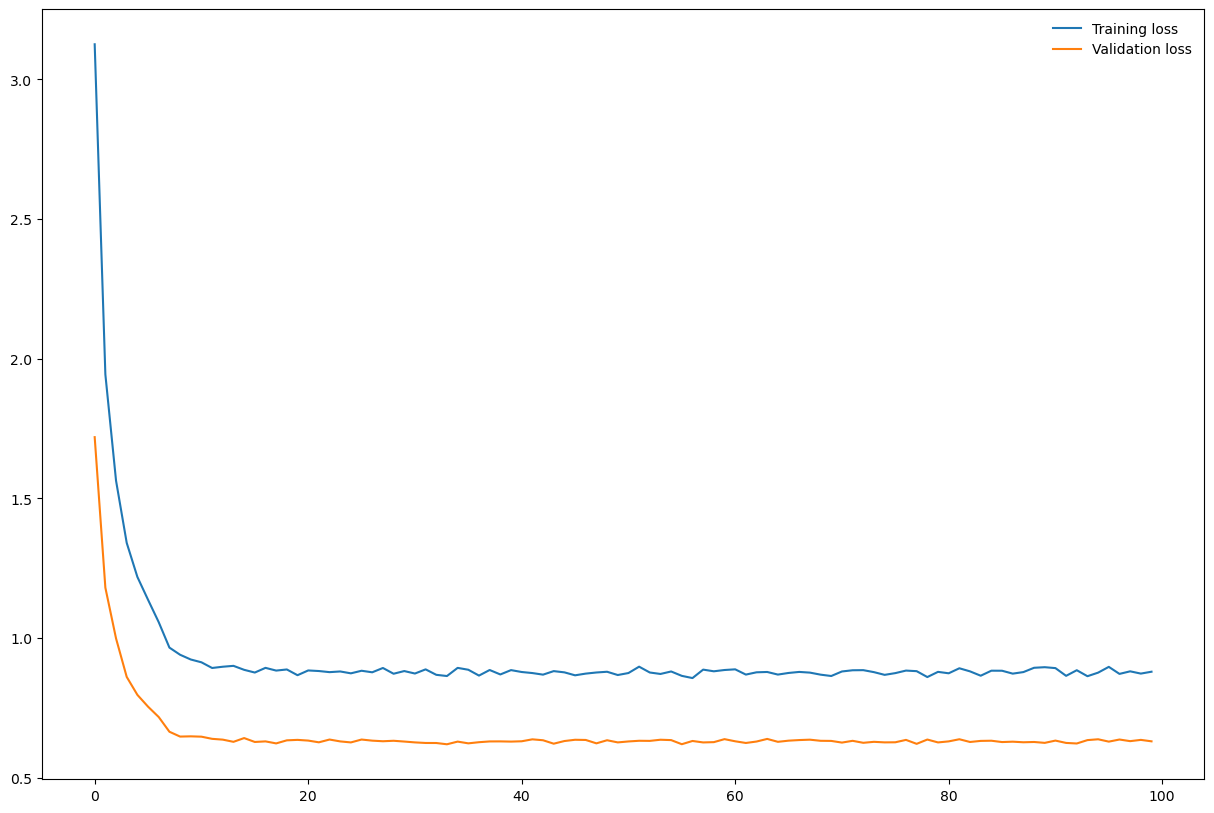

In [6]:
#Plot training and validation loss
import matplotlib.pyplot as plt
#plt figure size
plt.figure(figsize=(15,10))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)


In [7]:
val_losses.index(min(val_losses))
val_losses[20]

0.6324033797537622

# Conclusion
In this article, we have demonstrated the process of fruit classification using transfer learning with a pre-trained ResNet-18 model. By leveraging the power of deep learning and the feature extraction capabilities of the pre-trained model, we can accurately classify different fruits. This technology has broad applications, ranging from automated fruit classification in the agricultural industry to quality.